### Calculate the policy of the agent
* State Variable: x = [w, n, e, s, A], action variable a = [c, b, k], both of them are numpy array 

In [28]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline as RS
from multiprocessing import Pool
from functools import partial 
from pyswarm import pso
import warnings
from scipy import optimize

warnings.filterwarnings("ignore")
np.printoptions(precision=2)
# time line
T_min = 0
T_max = 70
T_R = 45
beta = 1/(1+0.02)
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate 
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])
# expected return on stock market 
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# probability of employment transition 
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# deterministic income
detEarning = np.load("detEarning.npy")
# tax rate 
tau_L = 0.2
tau_R = 0.1
# minimum consumption
c_bar = 3

Populating the interactive namespace from numpy and matplotlib


In [29]:
import nevergrad as ng
optimizer = ng.optimizers.PSO(parametrization=2, budget=1000)
optimizer.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
optimizer.parametrization.register_cheap_constraint(lambda x: x[0] <= 1)
optimizer.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
optimizer.parametrization.register_cheap_constraint(lambda x: x[1] <= 1)

In [30]:
#Define the utility function
def u(c):
    gamma = 2
    return (np.float_power(max(c-c_bar,0),1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth 
def uB(w):
    B = 2
    return B*u(w+1)

#Define the earning function 
def y(t, x):
    w, n, s, e, A = x
    if A == 0:
        return 0
    else:
        if t <= T_R:
            return detEarning[t] * earningShock[int(s)] * e + (1-e) * 5
        else:
            return detEarning[t]

# Define the reward funtion
def R(x, a):
    c, b, k = a
    w, n, s, e, A = x
    if A == 0:
        return uB(w+n)
    else:
        return u(c)

# Define the transtiion of state (test)
def transition(x, a, t):
    '''
        Input: x current state: (w, n, h_lag, e, s, A) 
               a action taken: (c, b, k, h)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    w, n, s, e, A = x
    
    x_next = []
    prob_next = []
    # Agent is dead 
    if A == 0:
        for s_next in [0, 1]:
            x_next.append([0, 0, s_next, 0, 0])
        return np.array(x_next), Ps[int(s)]
    else:
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        # calcualte n_next 
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+r_bar)
            else:
                n_next = n*(1+r_bar)
                
            # for potential s_next, e_next and A_next 
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for e_next in [0,1]:
                    for A_next in [0,1]:
                        x_next.append([w_next, n_next, s_next, e_next, A_next])
                        prob_next.append(Ps[int(s),s_next] * Pat[A_next] * Pe[int(s),s_next,int(e),e_next])    
                
        else:
            # after retirement agents withdraw cash from 401k
            n_next = n*(1+r_bar)-n/discounting
            e_next = 0
            
            # for potential s_next and A_next
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for A_next in [0,1]:
                    x_next.append([w_next, n_next, s_next, e_next, A_next])
                    prob_next.append(Pat[A_next] * Ps[int(s), s_next]) 
    return np.array(x_next), np.array(prob_next)
    
    
# Value function is a function of state and time t
def V(x, t, Vmodel, cons):
    # Define the objective function as a function of action
    w, n, s, e, A = x
    if A == 0:
        return np.array([R(x,[0,0,0]),[0,0,0]])
    else: 
        N, discounting = cons
        n_discount = n/discounting
        ytx = y(t, x)
        def obj(thetaTheta):
            theta1,theta2 = thetaTheta
            if t < T_R:
                if e == 1:
                    bk = ((1-tau_L)*(ytx * 0.95) + w) * theta1
                    c = ((1-tau_L)*(ytx * 0.95) + w) *(1-theta1)
                else:
                    bk = ((1-tau_L)*ytx + w) * theta1
                    c = ((1-tau_L)*ytx + w) * (1-theta1)
            else:
                bk = ((1-tau_R)*ytx + w + n_discount) * theta1
                c = ((1-tau_R)*ytx + w + n_discount) * (1-theta1)
            b = bk * theta2
            k = bk * (1-theta2)
            a = (c,b,k)
            x_next, prob_next = transition(x, a, t)
            return -(R(x, a) + beta * np.dot(Vmodel[int(s)][int(e)][int(A)].ev(x_next[:,0], x_next[:,1]), prob_next))
        
        xopt = optimizer.minimize(obj).value 
        fopt = -obj(xopt)
        max_val = -fopt
        theta1_m, theta2_m = xopt
        
        if t < T_R:
            if e == 1:
                bk_m = ((1-tau_L)*(ytx * 0.95) + w) * theta1_m
                c_m = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1_m)
            else:
                bk_m = ((1-tau_L)*ytx + w) * theta1_m
                c_m = ((1-tau_L)*ytx + w) * (1-theta1_m)
        else:
            bk_m = ((1-tau_R)*ytx + w + n_discount) * theta1_m
            c_m = ((1-tau_R)*ytx + w + n_discount) * (1-theta1_m)
        b_m = bk_m * theta2_m
        k_m = bk_m * (1-theta2_m)
        return np.array([max_val, [c_m, b_m, k_m]])

In [31]:
# wealth discretization 
w_grid_size = 100
w_lower = 3
w_upper = 20000
# 401k amount discretization 
n_grid_size = 50
n_lower = 3
n_upper = 10000

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)

# initialize the state discretization 
x_T = np.array([[w,n,e,s,0]   for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

xgrid = np.array([[w,n,e,s,A] for w in powspace(w_lower, w_upper, 3, w_grid_size)
                            for n in powspace(n_lower, n_upper, 3, n_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

Vgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
cgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
bgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
kgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = x_T):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))))).reshape((w_grid_size, n_grid_size, 2,2,2))

Vgrid[:,:,:,:,:, T_max] = applyFunToCalculateValue(partial(R, a = [0,0,0]), x = x_T)

### Backward Induction Part

69


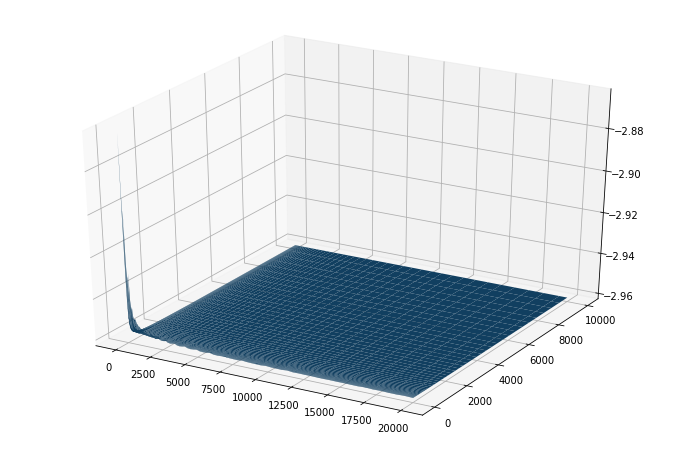

68


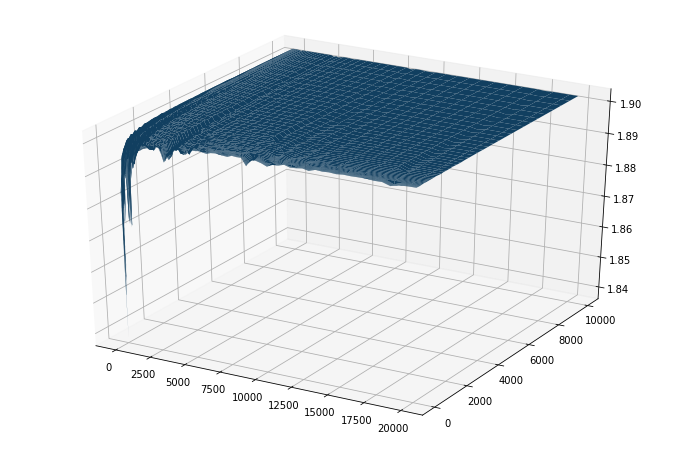

67


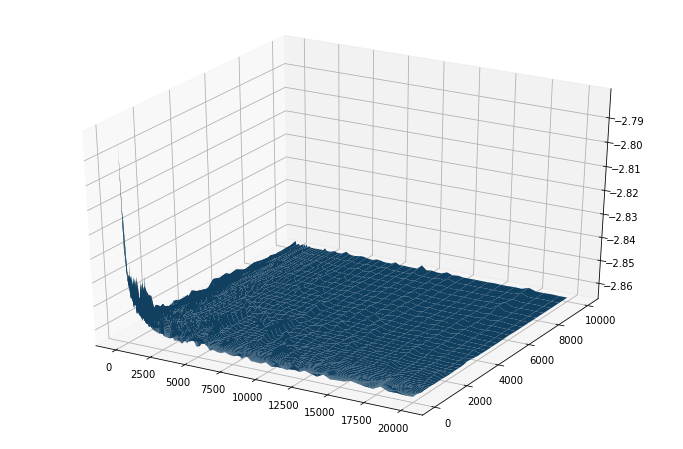

66


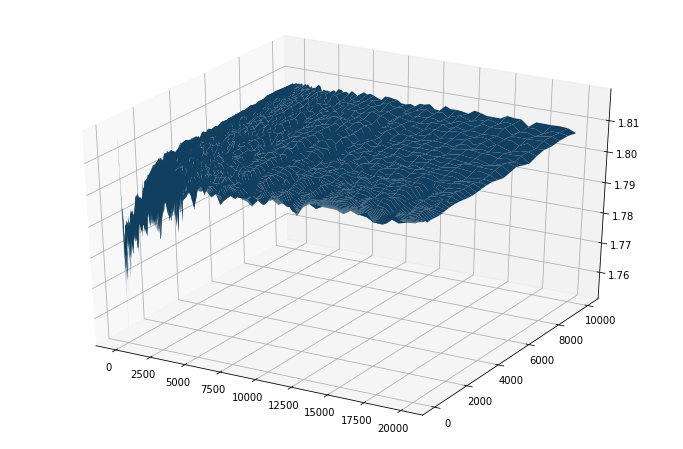

65


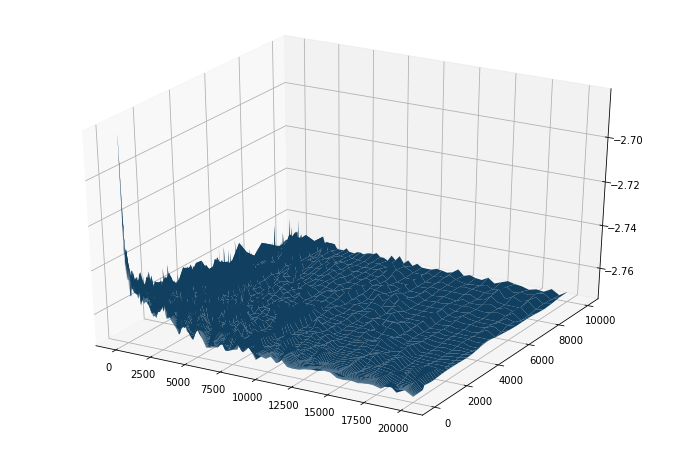

64


Process ForkPoolWorker-378:
Process ForkPoolWorker-402:
Process ForkPoolWorker-382:
Process ForkPoolWorker-377:
Process ForkPoolWorker-403:
Process ForkPoolWorker-380:
Process ForkPoolWorker-381:
Process ForkPoolWorker-375:
Process ForkPoolWorker-389:
Process ForkPoolWorker-394:
Process ForkPoolWorker-393:
Process ForkPoolWorker-392:
Process ForkPoolWorker-379:
Process ForkPoolWorker-396:
Process ForkPoolWorker-374:
Process ForkPoolWorker-397:
Process ForkPoolWorker-383:
Process ForkPoolWorker-401:
Process ForkPoolWorker-398:


KeyboardInterrupt: 

Process ForkPoolWorker-386:
Process ForkPoolWorker-385:
Process ForkPoolWorker-376:
Process ForkPoolWorker-391:
Process ForkPoolWorker-390:
Process ForkPoolWorker-395:
Process ForkPoolWorker-404:
Process ForkPoolWorker-399:
Process ForkPoolWorker-384:
Process ForkPoolWorker-388:
Process ForkPoolWorker-400:
Process ForkPoolWorker-387:
Process ForkPoolWorker-405:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home

  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._k

  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hfsluser/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
  

In [32]:
%%time 
ws = powspace(w_lower, w_upper, 3, w_grid_size)
ns = powspace(n_lower, n_upper, 3, n_grid_size)

xs = xgrid.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))

pool = Pool()

for t in range(T_max-1, 0, -1):
    print(t)
    # after retirement calculate the annuity payment
    N = np.sum(Pa[t:])
    discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
    cons = [N, discounting]
    
    cs = [[[RS(ws, ns, Vgrid[:,:,s,e,A,t+1]) for A in [0,1]] for e in [0,1]] for s in [0,1]]
    f = partial(V, t = t, Vmodel = cs, cons = cons)
    results = np.array(pool.map(f, xs))   
    Vgrid[:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size, 2,2,2))
    #########################################################[test function part] 
    fig = plt.figure(figsize = [12, 8])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X = xgrid[:,:,1,1,1,0], Y = xgrid[:,:,1,1,1,1], Z=Vgrid[:,:,1,1,1,t])
    plt.show()
    #########################################################
    cgrid[:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    bgrid[:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    kgrid[:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
pool.close()

In [ ]:
# np.save("Vgrid", Vgrid)
# np.save("cgrid", cgrid)
# np.save("bgrid", bgrid)
# np.save("kgrid", kgrid)

In [6]:
# ws = powspace(w_lower, w_upper, 3, w_grid_size)
# ns = powspace(n_lower, n_upper, 3, n_grid_size)
# Vgrid = np.load("Vgrid.npy")
# cgrid = np.load("cgrid.npy")
# bgrid = np.load("bgrid.npy")
# kgrid = np.load("kgrid.npy")

### Summary Plot 

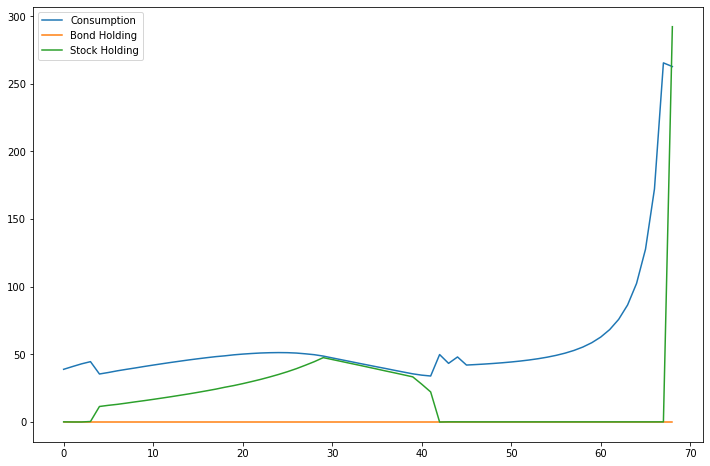

In [7]:
def summaryPlotChoiceVStime(w_level, n_level, s, e, A, C = cgrid, B = bgrid, K = kgrid):
    c = []
    b = []
    k = []
    for t in range(1,T_max):
        c.append(RS(ws, ns, C[:,:,s,e,A,t])(w_level, n_level)[0])
        b.append(RS(ws, ns, B[:,:,s,e,A,t])(w_level, n_level)[0])
        k.append(RS(ws, ns, K[:,:,s,e,A,t])(w_level, n_level)[0])
    plt.figure(figsize = [12,8])
    plt.plot(c, label = "Consumption")
    plt.plot(b, label= "Bond Holding")
    plt.plot(k, label="Stock Holding")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(5, 60, 1, 1, 1)

In [ ]:
# %matplotlib notebook
def summaryPlot_WandN_VS_Choice(t, s, e, A, C = cgrid, B = bgrid, K = kgrid):
    fig = plt.figure(figsize = [12,8])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X = xgrid[:,:,1,1,1,0], Y = xgrid[:,:,1,1,1,1], Z = cgrid[:,:,s,e,A,t], label="Consumption")
    ax.plot_surface(X = xgrid[:,:,1,1,1,0], Y = xgrid[:,:,1,1,1,1], Z = bgrid[:,:,s,e,A,t], label="Bond Holding")
    ax.plot_surface(X = xgrid[:,:,1,1,1,0], Y = xgrid[:,:,1,1,1,1], Z = kgrid[:,:,s,e,A,t], label="Stock Holding")
    plt.show()
summaryPlot_WandN_VS_Choice(60, 1, 1, 1)

### Simulation Part

In [ ]:
import quantecon as qe
mc = qe.MarkovChain(Ps)

def action(t, x):
    w,n,s,e,A = x
    if A == 1:
        c = RS(ws, ns, cgrid[:,:,s,e,A,t])(w, n)[0][0]
        b = RS(ws, ns, bgrid[:,:,s,e,A,t])(w, n)[0][0]
        k = RS(ws, ns, kgrid[:,:,s,e,A,t])(w, n)[0][0]
    else:
        c = 0
        b = 0
        k = 0
    return (c,b,k)

# Define the transition of state (test)
def transition(x, a, t, s_next):
    '''
        Input: x current state: (w, n, s, e, A) 
               a action taken: (c, b, k)
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    w, n, s, e, A = x
    
    x_next = []
    prob_next = []
    # Agent is dead 
    if A == 0:
        return [0,0,s_next,0,0]
    else:
        # after retirement calculate the annuity payment
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        # A = 1, agent is still alive and for the next period
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+0.02)
            else:
                n_next = n*(1+0.02)
        else:
            n_next = (n-n/discounting)*(1+0.02)
        r_stock = r_m[int(s), s_next]
        w_next =  b*(1+r_bond) + k*(1+r_stock)
        
        for e_next in [0,1]:
            for A_next in [0,1]:
                if A_next == 0:
                    x_next.append([w_next, n*(1+0.02), s_next, 0, 0])
                else:
                    # Age reaches 65 or agent is dead directly results in unemployment
                    if t >= T_R:
                        x_next.append([w_next, n_next, s_next, 0, 1])
                    else:
                        x_next.append([w_next, n_next, s_next, e_next, 1])
                prob_next.append(Pat[A_next] * Pe[int(s),s_next,int(e),e_next])
        return x_next[np.random.choice(4, 1, p = prob_next)[0]]

In [ ]:
numEcon = 500
sim = 1000
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcon)]
# simulate an agent age 0 starting with wealth of 20 and 20 in rFund.
def simulateAgent(i):
    # states
    wealth = []
    rFund = []
    employ = []
    live = []
    Salary = []
    # actions 
    Consumption = []
    Bond = []
    Stock = []
    if np.random.rand() > 0.95:
        x = [20, 0, 0, 0, 1]
    else:
        x = [20, 0, 0, 1, 1]
    econState = EconStates[i//sim]
    for t in range(len(econState)-1):
        s = econState[t]
        s_next = econState[t+1]
        a = action(t, x)
        c, b, k = a
        w, n, _, e, A = x
        
        wealth.append(w)
        rFund.append(n)
        Consumption.append(c)
        Bond.append(b)
        Stock.append(k)
        Salary.append(y(t, x))
        employ.append(e)
        live.append(A)
        x = transition(x, a, t, s_next)
    # list of array 
    return np.array([wealth, rFund, Consumption, Bond, Stock, Salary, employ, live]).T

In [ ]:
%%time 
pool = Pool()
agents = pool.map(simulateAgent, list(range(sim*numEcon)))
pool.close()

In [ ]:
np.save("agents", agents)

### Summary statistics of the simulation 

In [ ]:
import numpy as np
agents = np.load("agents.npy")

In [ ]:
# wealth, rFund, Consumption, Bond, Stock, Salary, employ, live
def collect(attribute, agents):
    names = ["wealth", "rFund", "Consumption", "Bond", "Stock", "Salary", "employ", "live"]
    index = names.index(attribute)
    container = np.zeros((agents[0].shape[0],len(agents)))
    for i in range(len(agents)):
        container[:, i] = agents[i][:, index]
    return container

In [ ]:
wealth = collect("wealth",agents)
rFund = collect("rFund",agents)
Consumption = collect("Consumption",agents)
Bond = collect("Bond",agents)
Stock = collect("Stock",agents)
Salary = collect("Salary",agents)
employ = collect("employ",agents)
live = collect("live",agents)

In [ ]:
# Population during the entire simulation period
plt.plot(np.mean(live, axis = 1))

In [ ]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(69):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(live[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(69):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(live[i,:] == 1)]))
    return np.array(means)

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(wealth))

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(rFund))

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Consumption))

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Bond))

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Stock))

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Salary))

In [ ]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(wealth), label = "wealth")
plt.plot(meanForPeopleWholive(rFund), label = "rFund")
plt.plot(meanForPeopleWholive(Consumption), label = "Consumption")
plt.plot(meanForPeopleWholive(Bond), label = "Bond")
plt.plot(meanForPeopleWholive(Stock), label = "Stock")
plt.plot(meanForPeopleWholive(Salary), label = "Salary")
plt.legend()

In [ ]:
# calculate fraction of consumption, stock investment, bond investment over (wealth + income)
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(Consumption)[:65]/meanForPeopleWholive(wealth+Salary)[:65], label = "Consumption")
plt.plot(meanForPeopleWholive(Bond)[1:66]/meanForPeopleWholive(wealth+Salary)[1:66], label = "Bond")
plt.plot(meanForPeopleWholive(Stock)[1:66]/meanForPeopleWholive(wealth+Salary)[1:66], label = "Stock")
plt.legend()

In [ ]:
plt.plot(meanForPeopleWholive(employ)[:45])